In [1]:
from src import *

## Description

Comparing aligned gradient's centroid and concentration and their evolution over time versus item timeseries

GOAL: Item timeseries correlation / metrics against centroid and concentration timeseries

## Table of Contents
- [Timeseries Comparison](#comparison)

In [2]:
['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Contempt','Anxiety', \
             'Satisfaction','Shame','Surprise','Love','Sad']

['Anger',
 'Guilt',
 'WarmHeartedness',
 'Disgust',
 'Happiness',
 'Fear',
 'Contempt',
 'Anxiety',
 'Satisfaction',
 'Shame',
 'Surprise',
 'Love',
 'Sad']

<a class="anchor" id="comparison"></a>
### Timeseries Comparison 
Comparison between item timeseries and centroid of region timeseries

Movie name used for gradient: `'TC_400_sub-S09_ses-4_Sintel.csv'`

In [43]:
# Loading Gradient Example
mri_path = "./data/fmri_compile.csv"
weight_path = "./resources/gradient_movie_ws140.npy"
mri_df   = pd.read_csv(mri_path)
G_movie  = np.load(weight_path)
G_rest   = np.load('./resources/gradient_rest_ws140.npy')


# Loading Matching Emotion Track
emo_df = pd.read_csv('./data/emotion_compile.csv')
emo_df = emo_df[emo_df['filename']=='W_Sintel13.csv']

In [44]:
index2region = load('./resources/yeo7region400.pkl')

Text(0.5, 0.98, 'Movie Gradient 1: region centroids position shift and concentration')

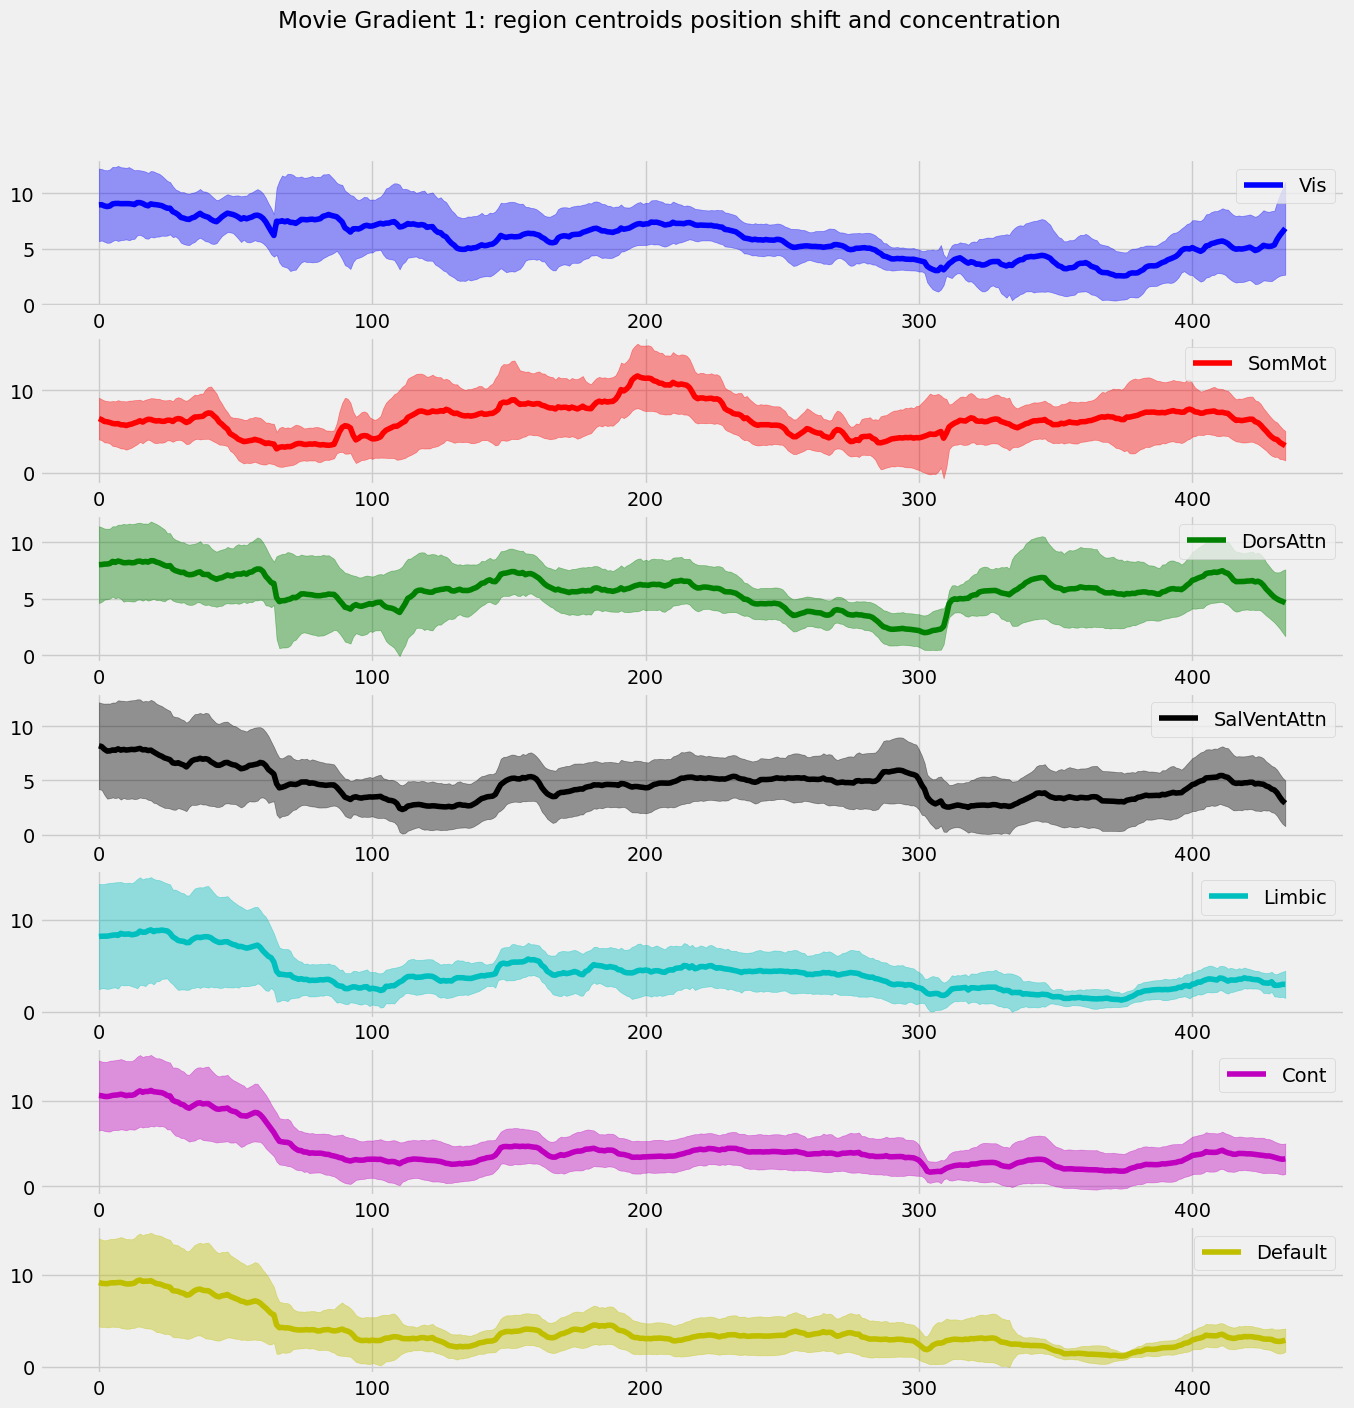

In [45]:
n = len(mri_df.partial_region.unique())
fig, ax = plt.subplots(n,1,figsize=(15,15))
grad_idx = 0
for idx, R in enumerate(mri_df.partial_region.unique()):
    y = np.abs(G_movie[:,index2region[R]]).mean(axis=1)[:,grad_idx]
    x = np.arange(len(y))
    error = np.abs(G_movie[:,index2region[R]]).std(axis=1)[:,grad_idx]

    ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    ax[idx].fill_between(x, y-error, y+error, color=PALETTE[idx], alpha=0.4)
    ax[idx].legend()
    # ax[idx].set_ylim(0, 30)
plt.suptitle("Movie Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

Text(0.5, 0.98, 'Movie Gradient 1: region concentration')

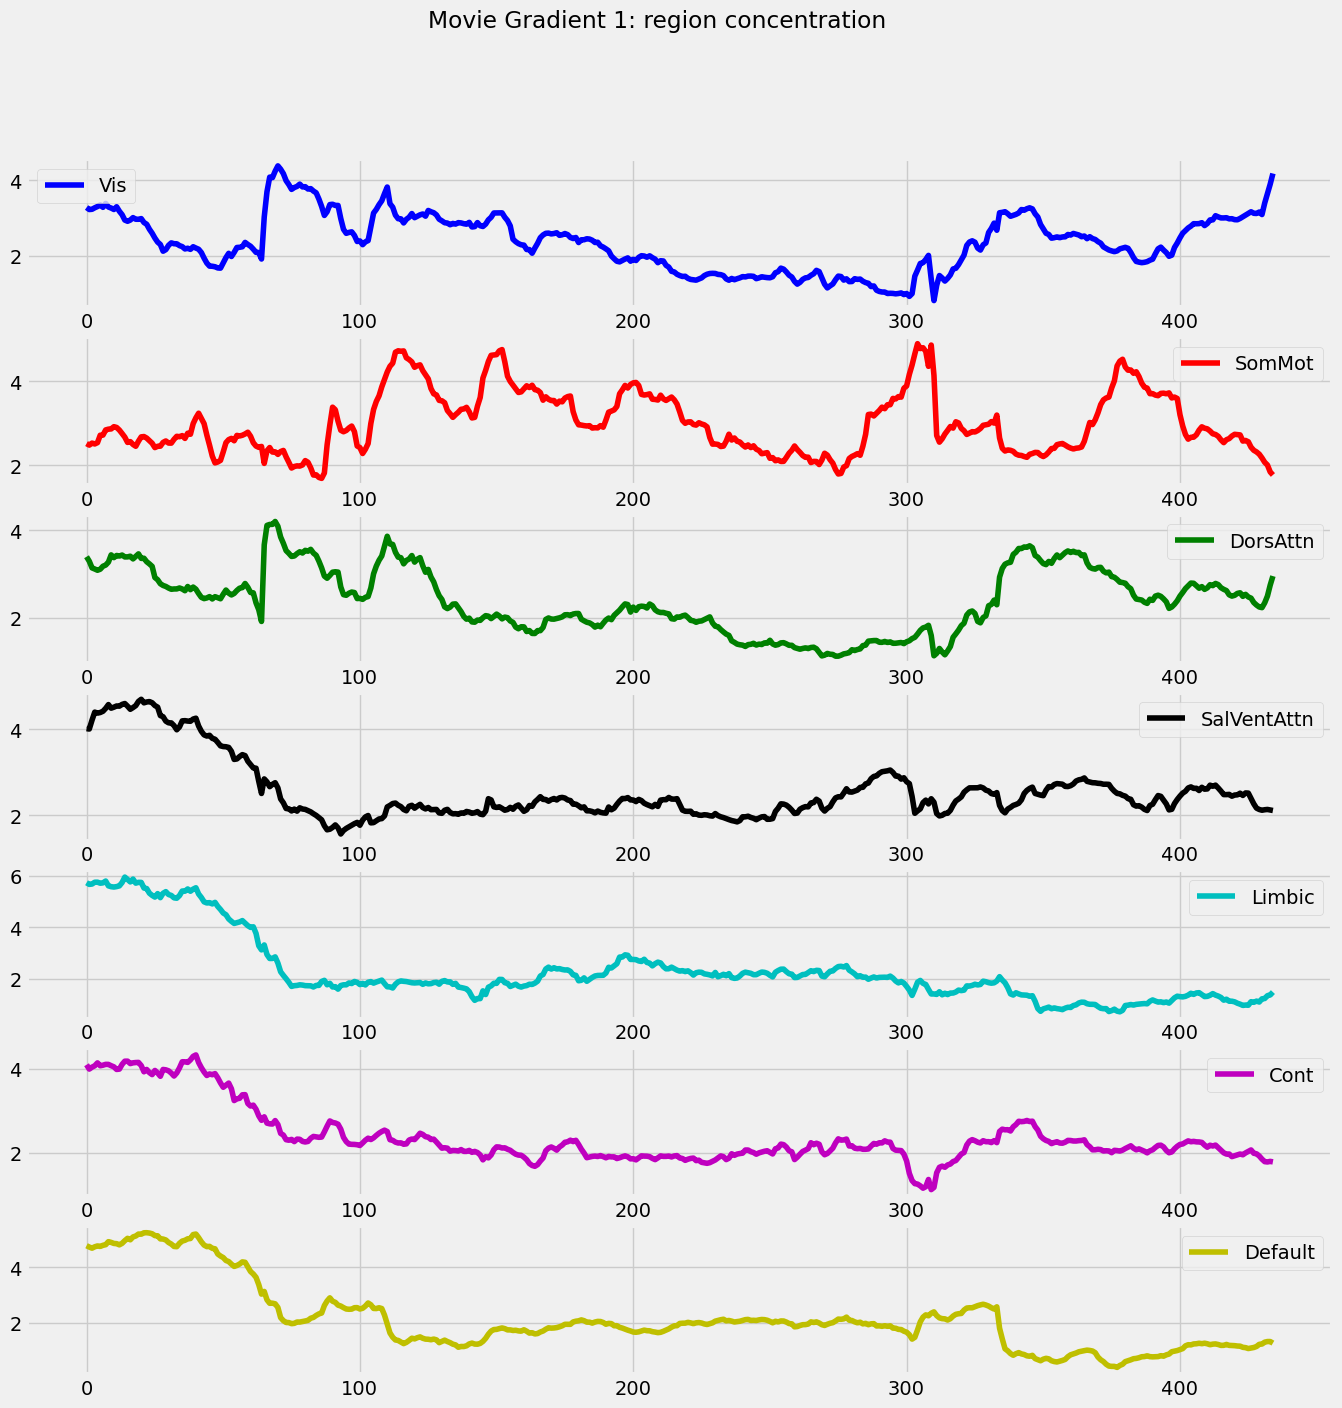

In [46]:
n = len(mri_df.partial_region.unique())
fig, ax = plt.subplots(n,1,figsize=(15,15))
grad_idx = 0
for idx, R in enumerate(mri_df.partial_region.unique()):
    y = np.abs(G_movie[:,index2region[R]]).std(axis=1)[:,grad_idx]
    x = np.arange(len(y))
    ax[idx].plot(x,y, color=PALETTE[idx], label=R)
    ax[idx].legend()
    # ax[idx].set_ylim(0, 30)
plt.suptitle("Movie Gradient {}: region concentration".format(grad_idx + 1))

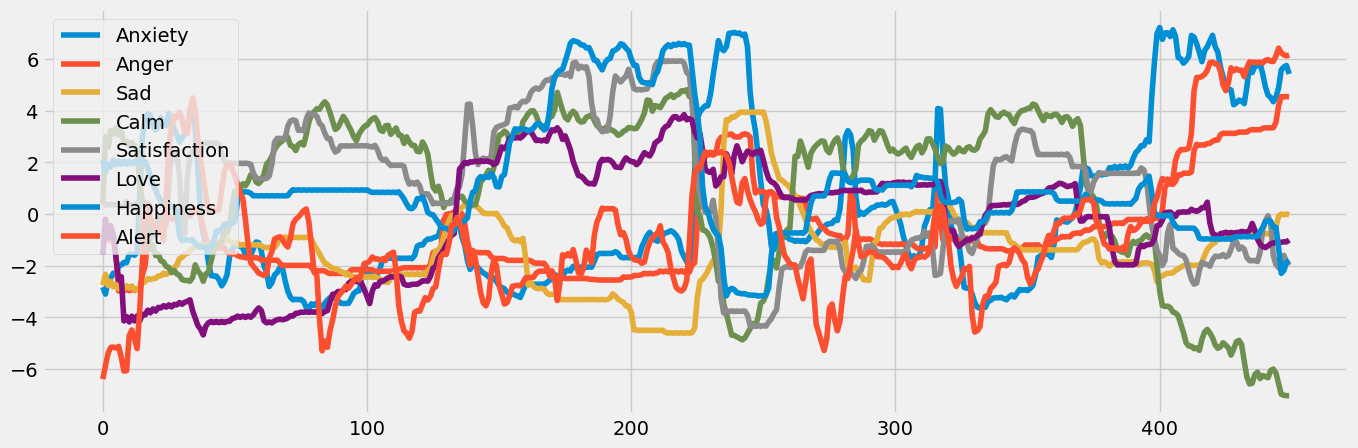

In [47]:
# emotions = "Interest, Joy, Surprise, Sadness, Anger, Disgust, Contempt, Self-Hostility, Fear, Shame, Shyness, Guilt".split(',')
select   = ["Anxiety", "Anger", "Sad",  "Calm", "Satisfaction",  "Love", "Happiness", "Alert"]

plt.figure(figsize=(15,5))
for emotion in select:
    emo_series = np.array(emo_df[emo_df.item==emotion]['score'])[:450]
    plt.plot(emo_series, label=emotion)

plt.legend()

In [48]:
# Grid for each region of correlation with items

grad_idx = 0
select   = ["Anxiety", "Anger", "Sad",  "Calm", "Satisfaction",  "Love", "Happiness", "Alert"]
regions  = mri_df.partial_region.unique()
smfactor = 1
tolshift = 0

n = len(regions)
m = len(select)

scores = np.zeros((n,m))

for idx, R in enumerate(regions):
    # Metric we use here would be variance of a cluster
    # y = np.abs(G_movie[:,index2region[R]]).std(axis=1)[:,grad_idx]
    y = np.abs(G_movie[:,index2region[R]]).mean(axis=1)[:,grad_idx]
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        corr = correlation_search(z1,z2, tolshift)
        scores[idx,jdx] = corr

We select here the max and visualize how well they correlate each other

In [49]:
scores.max(), scores.argmax(), scores.argmax()//m, scores.argmax()%m

(0.5764262456356524, 14, 1, 6)

In [50]:
a = np.abs(G_movie[:,index2region[regions[1]]]).mean(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[6]]['score'])
b = overlap_add(b, 1)

a, b = zscore(a), zscore(b)
correlation_search(a,b[:a.shape[0]], 0, 1)

(0.5764262456356524, (0, 0), 7.033996516642022e-40)

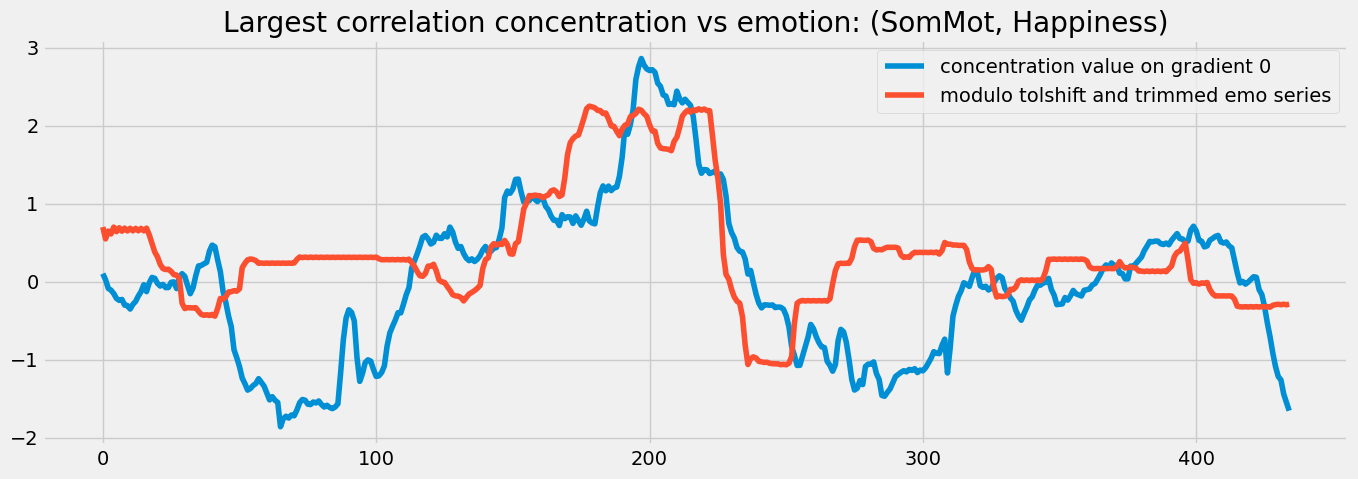

In [51]:
plt.figure(figsize=(15,5))
plt.plot(a, label='concentration value on gradient {}'.format(grad_idx))
plt.plot(b[:a.shape[0]], label='modulo tolshift and trimmed emo series')
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[1],select[6]))
plt.legend()

Distance between regions on gradients

0.32886136379486963
11.147343251319477


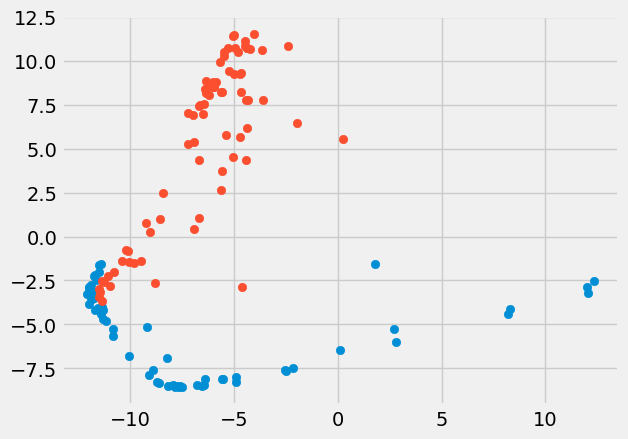

In [52]:
c1 = G_movie[0,index2region[regions[0]]]
c2 = G_movie[0,index2region[regions[1]]]

plt.scatter(c1[:,0], c1[:,1])
plt.scatter(c2[:,0], c2[:,1])

print(cluster_distance(c1,c2))
print(cluster_distance(c1,c2, method="centroid"))

In [53]:
regions

array(['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont',
       'Default'], dtype=object)

In [208]:
T = G_movie.shape[0]
C = np.zeros((T, n, n))
for t in tqdm(range(T)):
    for i, r1 in enumerate(regions):
        for j, r2 in enumerate(regions):
            c1 = G_movie[t, index2region[r1]]
            c2 = G_movie[t, index2region[r2]]
            C[t,i,j] = cluster_distance(c1,c2)

100%|██████████| 435/435 [02:47<00:00,  2.60it/s]


In [216]:
T = G_movie.shape[0]
C2 = np.zeros((T, n, n))
for t in tqdm(range(T)):
    for i, r1 in enumerate(regions):
        for j, r2 in enumerate(regions):
            c1 = G_movie[t, index2region[r1]]
            c2 = G_movie[t, index2region[r2]]
            C2[t,i,j] = cluster_distance(c1,c2, method="centroid")

100%|██████████| 435/435 [00:00<00:00, 883.73it/s]


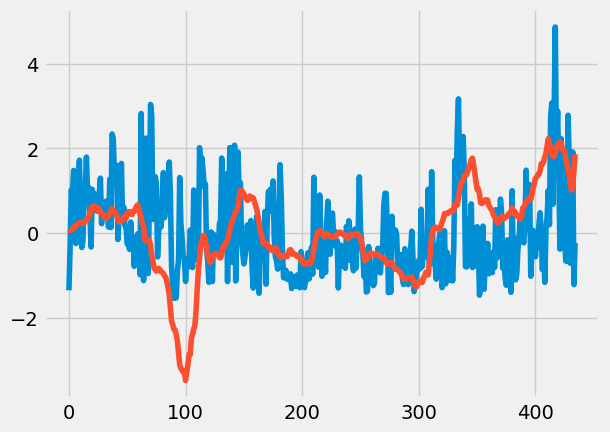

In [222]:
plt.plot(zscore(C[:,2,-1]))
plt.plot(zscore(C2[:,2,-1]))

Heat map of motion of regions

In [37]:
from nilearn.connectome import ConnectivityMeasure
from brainspace.gradient import GradientMaps

from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69

In [55]:
d_movie = []
d_rest  = []

for r in range(G_movie.shape[1]):
    tmpA = G_movie[:, r][:-1]
    tmpB = G_movie[:, r][1:]

    D = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") for pidx in range(len(tmpA))])
    d_movie.append(D.mean())

for r in range(G_rest.shape[1]):
    tmpA = G_rest[:, r][:-1]
    tmpB = G_rest[:, r][1:]

    D = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") for pidx in range(len(tmpA))])
    d_rest.append(D.mean())

d_movie = np.asarray(d_movie)
d_rest  = np.asarray(d_rest)

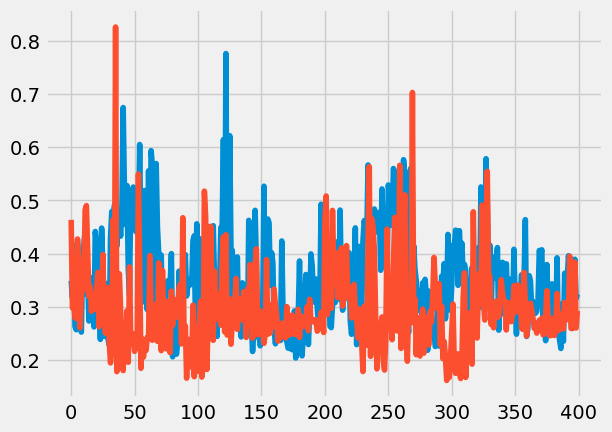

In [58]:
plt.plot(d_movie)
plt.plot(d_rest)

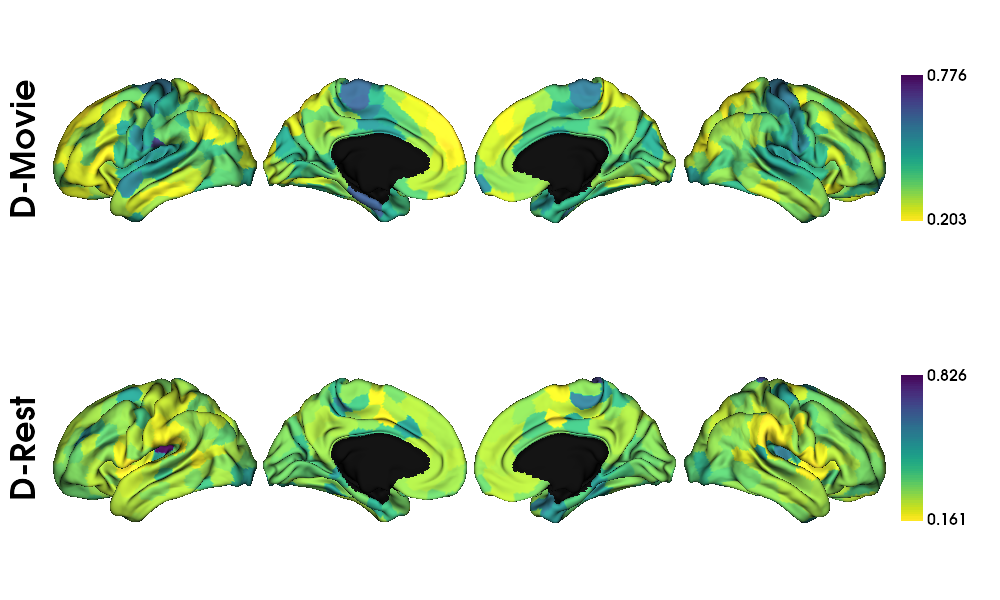

: 

In [61]:
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()


mask = labeling != 0
gs   = [d_movie, d_rest]
grad = [None] * 2
for k in range(2):
    # map the gradient to the parcels
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
                 color_bar=True, label_text=['D-Movie', 'D-Rest'], zoom=1.25, embed_nb=True, interactive=False)
